In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import randrange, uniform
from scipy.stats import norm
import math

In [34]:
def Objective_Function3(variance=10,lengthscale=1.2, seed=1):

  np.random.seed(seed) 
  temp = float(np.random.uniform(low=-2, high=2, size=1))
  
  bounds=np.asarray([[0.,5.5],[0.,5.5],[0.,5.5]])
  dim = bounds.shape[0]
  
  X_total = []
  
  for a in range(12):
    for b in range(12):
      for c in range (12):
        X_temp = np.array([a*0.5,b*0.5,c*0.5])
        X_total.append(X_temp)
      
  X_total = np.array(X_total)


  X_sample=np.array([[5.1,3.8,1.1]])
  Y_sample=np.array([[temp]])

  kernel = GPy.kern.RBF(input_dim=3,variance=variance,lengthscale=lengthscale)
  m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
  m.Gaussian_noise.variance.fix(0.0)

  Y_total = m.posterior_samples_f(X_total,size=1).reshape(-1,1)

  return X_total, Y_total


def init(X_total, Y_total,seed=1):
  
  np.random.seed(seed)

  X_sample = []
  Y_sample = []
  
  
  x_index_holder = [3,20,100,210,300,450,600,700,900,1100,1410,1550] # 12 initial points


  for idx in x_index_holder:
    X_temp = X_total[idx]           #int(np.random.randint(40, size=1))
    Y_temp =  Y_total[idx]           #int(np.random.randint(40, size=1))

    X_sample.append(X_temp)
    Y_sample.append(Y_temp)

  return np.array(X_sample),np.array(Y_sample)


def EI(mean,var,y_max):

  z = (mean - y_max)/np.sqrt(var)        
  out=(mean - y_max) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)

  return out 

def findmax(mean,var,fstar):
   pdf_fmax = 1/(np.sqrt(2*np.pi*var))*np.exp(-(fstar-mean)**2/(2*var))

   return pdf_fmax
 

def MSE(mean,var,fstar):
    
  gamma = (fstar-mean)/np.sqrt(var)  
  
  out = (gamma*norm.pdf(gamma))/(2*norm.cdf(gamma))-np.log(norm.cdf(gamma))

  return out 

def over_max(mean,var,fstar):
  z = (fstar - mean)/np.sqrt(var)   
  below_max = norm.cdf(z)
  out = 1 - below_max
  
  return out 

In [35]:
def normal_BO(X_total,Y_total,acq,fstar, seed = 1): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar_true = np.max(Y_total)
  
  total_round = 20
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    kernel = GPy.kern.RBF(input_dim=3,variance=10,lengthscale=1.2)
    m = GPy.models.GPRegression(X_sample,Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)

    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total,include_likelihood=False)

    #print(mean[mean>fstar])

    if acq == 'ei':
      acq_value = EI(mean,var,Y_max_holder[-1])
      
    elif acq=='find_max':
      acq_value = findmax(mean,var,fstar)
    
    elif acq == 'mes':
      acq_value = MSE(mean,var,fstar)
      
    elif acq == 'over_max':
      acq_value = over_max(mean,var,fstar)
      
    elif acq == 'tei':
      part1 = EI(mean,var,Y_max_holder[-1])
      part2 = EI(mean,var,fstar)
      acq_value = part1-part2

    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    Y_chosen = Y_total[index]

    X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,3)), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder

In [36]:
def PO_BO(X_total,Y_total, fstar,seed = 1): #the shape of X_total is (2500,2), the shape of Y_total is (50,50)

  fstar_true = np.max(Y_total)
    
  total_round = 20
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed=seed)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  for n in range(total_round):
    print(n)
    #train the GP model for X and centrailised Y
    kernel = GPy.kern.RBF(input_dim=3,variance=10,lengthscale=1.2)
    m = GPy.models.GPRegression(X_sample,Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)

    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total,include_likelihood=False)

    part1_total = findmax(mean,var,fstar)
    part1_total = part1_total.reshape(-1,)

    part2_total = np.zeros(X_total.shape[0])

    for i in range(X_total.shape[0]):
        X_sample_temp = np.concatenate((X_sample, np.array([X_total[i]])), axis=0)
        Y_sample_temp = np.concatenate((Y_sample, np.array([[fstar]])), axis=0)

        X_current_0 = X_total[i][0]
        X0_lower = max(0.0,X_current_0-4*0.5)
        X0_upper = min(5.85,X_current_0+4*0.5)
        X0_range = np.arange(X0_lower,X0_upper,0.5)

        X_current_1 = X_total[i][1]
        X1_lower = max(0.0,X_current_1-4*0.5)
        X1_upper = min(5.85,X_current_1+4*0.5)
        X1_range = np.arange(X1_lower,X1_upper,0.5)
        
        X_current_2 = X_total[i][1]
        X2_lower = max(0.0,X_current_2-4*0.5)
        X2_upper = min(5.85,X_current_2+4*0.5)
        X2_range = np.arange(X2_lower,X2_upper,0.5)
        
        

        X_near = []

        for x0 in X0_range:
          for x1 in X1_range:
            for x2 in X2_range:
              X_near.append([x0,x1,x2])
        X_near = np.array(X_near)



        kernel_temp = GPy.kern.RBF(input_dim=3,variance=10,lengthscale=1.2)
        m_temp = GPy.models.GPRegression(X_sample_temp.reshape(-1,3),Y_sample_temp.reshape(-1,1),kernel_temp)
        m_temp.Gaussian_noise.variance.fix(0.0)

        mean_temp,var_temp = m_temp.predict(X_near,include_likelihood=False)
        z = (fstar-mean_temp)/np.sqrt(var_temp)
        PnI = norm.cdf(z)
        part2 = np.min(PnI)
        part2_total[i] = part2

    acq_value = part1_total*part2_total
    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    Y_chosen = Y_total[index]

    X_sample = np.concatenate((X_sample, X_chosen.reshape(-1,3)), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder

# experiment

fast algorithms

In [37]:
# regret_holder1 = []
# regret_holder2 = []
# regret_holder3 = []
# regret_holder4 = []
regret_holder5 = []

N = 50

for i in range(N):
  X_total, Y_total = Objective_Function3(variance=10,lengthscale=1.2,seed=i+100)
  fstar = np.max(Y_total)
  print('optimal: ',fstar)
  
  # regret_temp1 = normal_BO(X_total,Y_total,'ei',fstar,seed = i+50)
  # regret_holder1.append(regret_temp1)

  # regret_temp2 = normal_BO(X_total,Y_total,'tei',fstar,seed = i+50)
  # regret_holder2.append(regret_temp2)
  
  # regret_temp3 = normal_BO(X_total,Y_total,'mes',fstar,seed = i+50)
  # regret_holder3.append(regret_temp3)
  
  # regret_temp4 = normal_BO(X_total,Y_total,'find_max',fstar,seed = i+50)
  # regret_holder4.append(regret_temp4)
  
  regret_temp5 = PO_BO(X_total,Y_total,fstar,seed = i+100)
  regret_holder5.append(regret_temp5)
  

optimal:  7.848429964970127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  7.222640869214434
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  11.851232567052069
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  8.677863769340608
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  6.308701905454209
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  7.3606672240658355
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  7.695490056062541
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  8.299802079712027
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  8.649060029070407
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  6.123923399694729
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  8.375620539863549
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  7.006581664780167
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
optimal:  9.158217257554416
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14

In [38]:
regret_holder5

[array([1.76281111, 1.76281111, 1.76281111, 1.71980184, 0.1646095 ,
        0.07100658, 0.07100658, 0.07100658, 0.07100658, 0.07100658,
        0.07100658, 0.07100658, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 array([4.09734673e+00, 4.09734673e+00, 3.82895673e+00, 3.82895673e+00,
        3.78596314e+00, 3.78596314e+00, 1.41578082e+00, 1.41578082e+00,
        1.41578082e+00, 1.41578082e+00, 1.41578082e+00, 1.41578082e+00,
        5.10395508e-01, 5.10395508e-01, 3.38428596e-03, 3.38428596e-03,
        3.38428596e-03, 3.38428596e-03, 3.38428596e-03, 3.38428596e-03,
        3.38428596e-03]),
 array([5.2357159 , 5.2357159 , 5.2357159 , 5.2357159 , 4.81935657,
        4.81935657, 4.81935657, 1.94660301, 1.94660301, 1.94660301,
        1.94660301, 1.94660301, 1.94660301, 1.94660301, 1.94660301,
        1.94660301, 1.94660301, 1.94660301, 1.94660301, 1.94660301,
        0.        ]),
 array([0., 0., 0., 0., 0.

In [39]:
regret_holder5 = np.array(regret_holder5)
np.savetxt('GP3d_po100150', regret_holder5, delimiter=' ')

In [83]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)

logregret_holder1 = np.log(regret_holder1)
logregret_holder2 = np.log(regret_holder2)
logregret_holder3 = np.log(regret_holder3)

logregret_holder1[logregret_holder1 == float('-inf')] = -8
logregret_holder2[logregret_holder2 == float('-inf')] = -8
logregret_holder3[logregret_holder3 == float('-inf')] = -8


 /tmp/ipykernel_105091/1297033976.py:5: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_105091/1297033976.py:6: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_105091/1297033976.py:7: RuntimeWarning:divide by zero encountered in log


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


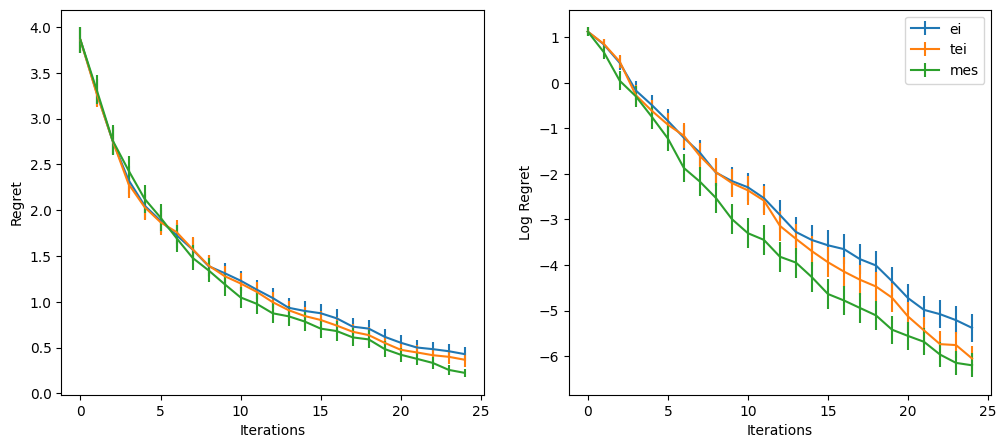

In [84]:
N = 150
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='mes')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='mes')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.legend()

In [ ]:
np.savetxt('GP3d_EI', regret_holder1, delimiter=' ')
np.savetxt('GP3d_TEI', regret_holder2, delimiter=' ')
np.savetxt('GP3d_MES', regret_holder3, delimiter=' ')

In [16]:
regret_holder4 = np.array(regret_holder44)

In [17]:
np.savetxt('GP3d_findmax', regret_holder4, delimiter=' ')

# Import data

In [70]:
with open('GP3d_EI', 'r') as f:
    regret_holder1 = np.loadtxt(f)
    
with open('GP3d_TEI', 'r') as f:
    regret_holder2 = np.loadtxt(f)
    
with open('GP3d_MES', 'r') as f:
    regret_holder3 = np.loadtxt(f)
    
with open('GP3d_findmax', 'r') as f:
    regret_holder4 = np.loadtxt(f)

In [40]:
regret_holder5_5070 = [[2.69210184, 2.69210184, 2.69210184, 2.69210184, 0.01455983,
        0.01455983, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [1.48462598, 1.48462598, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [5.77456449, 5.77456449, 5.77456449, 5.77456449, 5.77456449,
        5.77456449, 5.77456449, 5.77456449, 5.77456449, 5.77456449,
        5.77456449, 5.77456449, 5.77456449, 5.77456449, 5.77456449,
        5.77456449, 5.77456449, 5.77456449, 5.77456449, 5.21614745,
        5.21614745],
 [1.42754412, 1.42754412, 0.24030913, 0.24030913, 0.24030913,
        0.24030913, 0.24030913, 0.24030913, 0.24030913, 0.24030913,
        0.24030913, 0.24030913, 0.24030913, 0.24030913, 0.24030913,
        0.24030913, 0.24030913, 0.24030913, 0.24030913, 0.24030913,
        0.24030913],
 [3.98475819, 3.98475819, 0.78552041, 0.21768254, 0.21768254,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [3.38990101, 3.38990101, 3.38990101, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [1.77541389, 1.77541389, 1.77541389, 1.77541389, 1.77541389,
        1.77541389, 1.69311777, 1.69311777, 1.69311777, 1.69311777,
        1.69311777, 1.69311777, 1.69311777, 1.69311777, 1.41898299,
        1.41898299, 1.41898299, 1.41898299, 1.41898299, 1.41898299,
        1.41898299],
 [2.94854541, 2.72284862, 2.72284862, 2.72284862, 2.57891453,
        2.57891453, 2.57891453, 2.57891453, 1.69324627, 1.49389916,
        1.35199599, 1.08864152, 1.08864152, 1.08864152, 1.08864152,
        1.08864152, 1.08864152, 1.08864152, 0.        , 0.        ,
        0.        ],
 [1.52390097, 0.68493007, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [3.46419048, 3.32128956, 1.95830815, 1.95830815, 1.95830815,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [4.03858509, 4.03858509, 4.03858509, 4.03858509, 4.03858509,
        4.03858509, 4.03858509, 4.03858509, 4.03858509, 4.03858509,
        4.03858509, 4.03858509, 4.03858509, 2.93189129, 2.93189129,
        2.93189129, 2.93189129, 0.        , 0.        , 0.        ,
        0.        ],
 [4.96972303, 4.96972303, 3.53084029, 3.53084029, 3.53084029,
        3.53084029, 3.53084029, 3.53084029, 2.35388106, 2.35388106,
        2.35388106, 2.35388106, 2.35388106, 2.35388106, 2.35388106,
        2.35388106, 2.35388106, 1.20016569, 1.20016569, 1.20016569,
        0.95295684],
 [3.52013179, 3.52013179, 2.64672151, 2.64672151, 2.3732691 ,
        1.34311029, 1.34311029, 1.34311029, 1.34311029, 0.94172145,
        0.94172145, 0.94172145, 0.94172145, 0.94172145, 0.94172145,
        0.94172145, 0.94172145, 0.94172145, 0.94172145, 0.94172145,
        0.94172145],
 [5.85351674, 5.85351674, 5.85351674, 5.85351674, 5.37785226,
        5.37785226, 5.37785226, 5.37785226, 2.7842072 , 2.7842072 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [1.87036954, 1.64495958, 1.64495958, 1.64495958, 1.64495958,
        1.64495958, 1.64495958, 1.64495958, 1.64495958, 1.64495958,
        1.64495958, 0.58663212, 0.58663212, 0.58663212, 0.58663212,
        0.58663212, 0.58663212, 0.58663212, 0.58663212, 0.58663212,
        0.58663212],
 [3.07106564, 3.07106564, 2.47129471, 1.9237473 , 1.9237473 ,
        1.9237473 , 1.9237473 , 1.9237473 , 1.9237473 , 1.9237473 ,
        1.9237473 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [3.24674919, 3.24674919, 0.8559486 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [2.77765744, 2.77765744, 2.77765744, 2.77765744, 2.77765744,
        2.77765744, 2.77765744, 2.77765744, 1.67596186, 0.30530561,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [4.9315214 , 4.9315214 , 4.9315214 , 4.9315214 , 4.9315214 ,
        4.9315214 , 4.9315214 , 4.9315214 , 4.9315214 , 4.9315214 ,
        4.9315214 , 2.50283368, 1.13423706, 1.13423706, 1.13423706,
        1.13423706, 1.13423706, 1.13423706, 1.13423706, 1.13423706,
        1.13423706],
 [5.06492199, 5.06492199, 5.06492199, 5.06492199, 2.6342371 ,
        2.6342371 , 2.43311526, 0.39980598, 0.39980598, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]]

In [41]:
regret_holder5_7090=[[4.72490243, 0.69143608, 0.69143608, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [1.05847609, 1.05847609, 1.05847609, 0.58591917, 0.58591917,
        0.58591917, 0.58591917, 0.58591917, 0.58591917, 0.58591917,
        0.58591917, 0.58591917, 0.58591917, 0.58591917, 0.58591917,
        0.58591917, 0.58591917, 0.58591917, 0.58591917, 0.58591917,
        0.58591917],
 [6.57655972, 6.57655972, 6.57655972, 4.952152  , 2.03905343,
        2.03905343, 2.03905343, 2.03905343, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [2.13413819, 2.13413819, 2.00147209, 2.00147209, 2.00147209,
        0.24790916, 0.24790916, 0.24790916, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [5.54438777, 5.21861182, 5.21861182, 5.21861182, 5.21861182,
        5.21861182, 5.21861182, 5.21861182, 5.21861182, 5.21861182,
        5.1112836 , 5.1112836 , 5.1112836 , 5.1112836 , 5.1112836 ,
        5.1112836 , 5.1112836 , 5.1112836 , 5.1112836 , 5.1112836 ,
        5.1112836 ],
 [4.70430275, 4.70430275, 4.70430275, 4.70430275, 4.70430275,
        4.70430275, 4.70430275, 4.70430275, 4.70430275, 2.79829362,
        2.79829362, 1.15201907, 1.15201907, 0.86867252, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [2.63493681, 2.63493681, 2.63493681, 2.63493681, 2.63493681,
        2.63493681, 2.63493681, 2.63493681, 1.64273714, 1.64273714,
        1.64273714, 1.57433103, 1.57433103, 1.57433103, 1.57433103,
        1.57433103, 1.57433103, 0.17623282, 0.17623282, 0.17623282,
        0.17623282],
 [6.51409589, 6.51409589, 6.43964861, 3.19033261, 3.19033261,
        2.41830592, 2.41830592, 2.41830592, 2.41830592, 2.41830592,
        1.66724041, 1.4666619 , 0.16011227, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [4.17680041, 3.92529023, 3.92529023, 3.92529023, 3.22109885,
        3.22109885, 3.22109885, 3.22109885, 3.22109885, 3.22109885,
        3.22109885, 2.7850855 , 1.51836126, 1.51836126, 1.51836126,
        0.60716134, 0.60716134, 0.60716134, 0.60716134, 0.60716134,
        0.60716134],
 [3.76233156, 1.47461055, 0.99017116, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [2.17741135, 2.17741135, 2.17741135, 1.97426946, 1.97426946,
        0.18426582, 0.18426582, 0.18426582, 0.18426582, 0.18426582,
        0.18426582, 0.18426582, 0.18426582, 0.18426582, 0.18426582,
        0.18426582, 0.18426582, 0.18426582, 0.18426582, 0.18426582,
        0.18426582],
 [3.06753617, 3.06753617, 3.06753617, 3.06753617, 3.06753617,
        3.06753617, 3.06753617, 3.06753617, 3.06753617, 3.06753617,
        3.06753617, 3.06753617, 3.06753617, 3.06753617, 3.06753617,
        3.06753617, 3.06753617, 2.67950961, 2.67950961, 2.67950961,
        2.67950961],
 [5.84337187, 2.91283919, 2.91283919, 2.91283919, 2.15963567,
        2.15963567, 2.15963567, 2.15963567, 2.15963567, 2.15963567,
        2.15963567, 2.15963567, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [2.04858073, 2.04858073, 1.00145022, 0.78268431, 0.71355838,
        0.71355838, 0.71355838, 0.71355838, 0.71355838, 0.71355838,
        0.71355838, 0.71355838, 0.71355838, 0.71355838, 0.71355838,
        0.71355838, 0.68787875, 0.68787875, 0.68787875, 0.68787875,
        0.68787875],
 [2.63684884, 2.63684884, 1.13434879, 1.13434879, 1.13434879,
        0.96320406, 0.96320406, 0.96320406, 0.96320406, 0.96320406,
        0.96320406, 0.96320406, 0.96320406, 0.65840601, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [5.52431971, 1.97137034, 1.59727902, 1.59727902, 1.59727902,
        1.59727902, 1.59727902, 1.59727902, 1.59727902, 1.59727902,
        1.59727902, 1.59727902, 1.59727902, 1.59727902, 1.59727902,
        1.59727902, 1.59727902, 1.59727902, 1.59727902, 1.59727902,
        1.59727902],
 [3.39731586, 3.39731586, 3.39731586, 2.95554969, 2.95554969,
        2.95554969, 2.95554969, 1.9874446 , 1.9874446 , 1.9874446 ,
        1.9874446 , 1.9874446 , 1.9874446 , 1.9874446 , 1.9874446 ,
        1.9874446 , 0.62481039, 0.        , 0.        , 0.        ,
        0.        ],
 [2.59996436, 2.59996436, 2.59996436, 2.59996436, 2.59996436,
        2.59996436, 1.8251052 , 1.8251052 , 1.8251052 , 1.8251052 ,
        1.8251052 , 1.8251052 , 1.8251052 , 1.8251052 , 1.8251052 ,
        1.8251052 , 1.8251052 , 1.8251052 , 1.8251052 , 1.8251052 ,
        1.8251052 ],
 [3.32266164, 3.32266164, 3.32266164, 3.32266164, 3.32266164,
        3.32266164, 3.32266164, 3.32266164, 3.32266164, 3.32266164,
        3.32266164, 3.32266164, 3.32266164, 3.32266164, 3.32266164,
        2.23253017, 1.91076787, 1.81087026, 1.50387604, 1.50387604,
        0.64869964],
 [2.41847876, 2.41847876, 1.54903671, 1.50600879, 1.50600879,
        1.50600879, 0.27722799, 0.27722799, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]]

In [42]:
regret_holder5_90100 = [[5.27803728, 5.27803728, 4.42900051, 4.42900051, 0.61172223,
        0.61172223, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [3.42273174, 3.42273174, 3.42273174, 1.66277464, 0.12771431,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [2.51401263, 0.17958214, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [5.18334406, 5.18334406, 5.18334406, 2.50669085, 2.50669085,
        2.50669085, 2.50669085, 2.50669085, 2.50669085, 2.50669085,
        0.90927874, 0.90927874, 0.90927874, 0.90927874, 0.90927874,
        0.90927874, 0.90927874, 0.90927874, 0.90927874, 0.90927874,
        0.90927874],
 [4.41963291, 0.43039404, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [2.60480078, 1.39188786, 1.39188786, 1.07368946, 1.07368946,
        1.07368946, 1.07368946, 1.07368946, 1.07368946, 1.07368946,
        1.07368946, 1.07368946, 1.07368946, 1.07368946, 1.07368946,
        1.07368946, 1.07368946, 0.89634919, 0.7217528 , 0.        ,
        0.        ],
 [4.14543113, 2.09067125, 2.09067125, 2.09067125, 2.09067125,
        2.09067125, 2.09067125, 2.09067125, 2.09067125, 2.09067125,
        2.09067125, 2.09067125, 2.09067125, 2.09067125, 2.09067125,
        2.09067125, 2.09067125, 2.09067125, 2.09067125, 2.09067125,
        2.09067125],
 [2.0081508 , 2.0081508 , 2.0081508 , 1.781991  , 1.52665187,
        1.52665187, 1.13431954, 0.97720631, 0.97720631, 0.97720631,
        0.8026636 , 0.8026636 , 0.8026636 , 0.8026636 , 0.8026636 ,
        0.8026636 , 0.8026636 , 0.        , 0.        , 0.        ,
        0.        ],
 [2.58762308, 2.58762308, 2.58762308, 0.37179155, 0.37179155,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
 [5.35917933, 4.10180847, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]]

In [43]:
regret_holder5_50100 = regret_holder5_5070+regret_holder5_7090+regret_holder5_90100

In [44]:
regret_holder5_50100 = np.array(regret_holder5_50100)

In [45]:
np.savetxt('GP3d_po50100', regret_holder5_50100, delimiter=' ')

In [71]:
with open('GP3d_po50100', 'r') as f:
    regret_holderpo50100 = np.loadtxt(f)
    
with open('GP3d_po100150', 'r') as f:
    regret_holderpo100150 = np.loadtxt(f)

In [79]:
regret_holder5 = np.concatenate((regret_holderpo50100,regret_holderpo100150),axis=0)  

In [ ]:
np.savetxt('GP3d_po50150', regret_holder5, delimiter=' ')

In [60]:
regret_holder5.shape

(100, 21)

In [73]:
N = 100

regret_holder1 = np.array(regret_holder1)[:N,:21]
logregret_holder1 = np.log(regret_holder1)
logregret_holder1[logregret_holder1 == float('-inf')] = -8

regret_holder2 = np.array(regret_holder2)[:N,:21]
logregret_holder2 = np.log(regret_holder2)
logregret_holder2[logregret_holder2 == float('-inf')] = -8

regret_holder3 = np.array(regret_holder3)[:N,:21]
logregret_holder3 = np.log(regret_holder3)
logregret_holder3[logregret_holder3 == float('-inf')] = -8

regret_holder4 = np.array(regret_holder4)[:N,:21]
logregret_holder4 = np.log(regret_holder4)
logregret_holder4[logregret_holder4 == float('-inf')] = -8

regret_holder5 = np.array(regret_holder5)[:N,:21]
logregret_holder5 = np.log(regret_holder5)
logregret_holder5[logregret_holder5 == float('-inf')] = -8

 /tmp/ipykernel_93148/3262918155.py:4: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_93148/3262918155.py:8: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_93148/3262918155.py:12: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_93148/3262918155.py:16: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_93148/3262918155.py:20: RuntimeWarning:divide by zero encountered in log


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


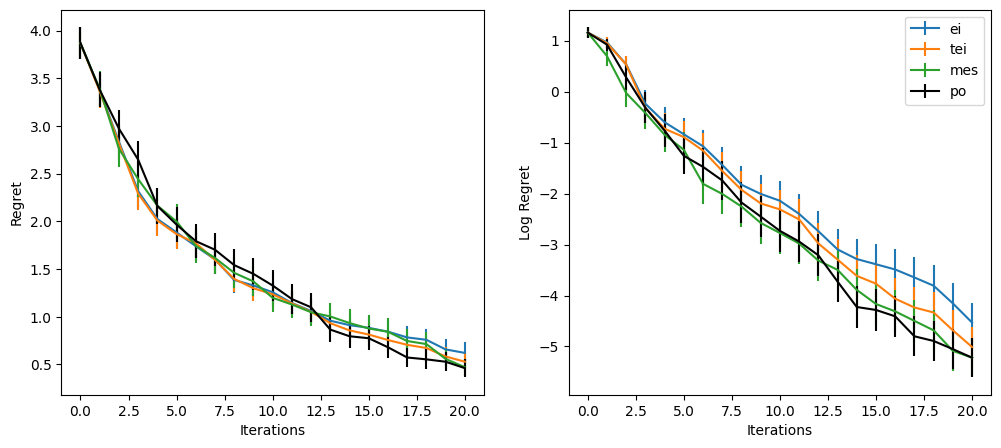

In [76]:
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='mes')
#ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='findmax')
ax.errorbar(myxaxis,np.mean(regret_holder5,axis=0),np.std(regret_holder5,axis=0)/np.sqrt(N),label='po',color='black')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='mes')
#ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='findmax')
ax2.errorbar(myxaxis,np.mean(logregret_holder5,axis=0),np.std(logregret_holder5,axis=0)/np.sqrt(N),label='po',color='black')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.legend()

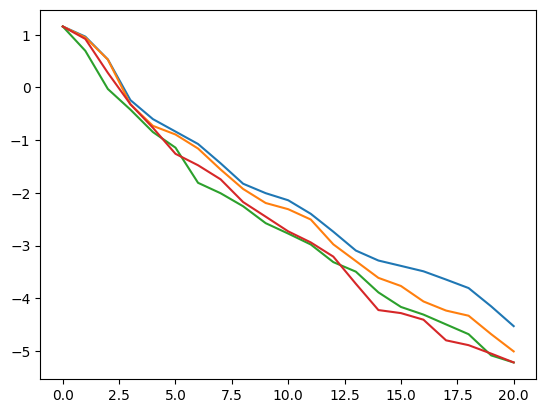

In [78]:
plt.plot(myxaxis,np.mean(logregret_holder1,axis=0),label='ei')
plt.plot(myxaxis,np.mean(logregret_holder2,axis=0),label='tei')
plt.plot(myxaxis,np.mean(logregret_holder3,axis=0),label='mes')
#plt.plot(myxaxis,np.mean(logregret_holder4,axis=0),label='findmax')
plt.plot(myxaxis,np.mean(logregret_holder5,axis=0),label='po')

 /tmp/ipykernel_93148/3210930861.py:15: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_93148/3210930861.py:19: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_93148/3210930861.py:23: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_93148/3210930861.py:27: RuntimeWarning:divide by zero encountered in log
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


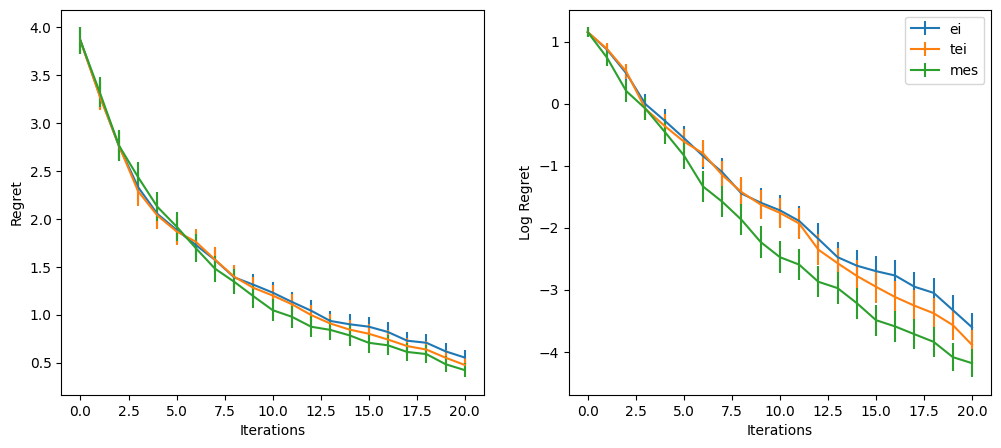

In [33]:
with open('GP3d_EI', 'r') as f:
    regret_holder1 = np.loadtxt(f)
    
with open('GP3d_TEI', 'r') as f:
    regret_holder2 = np.loadtxt(f)
    
with open('GP3d_MES', 'r') as f:
    regret_holder3 = np.loadtxt(f)
    
with open('GP3d_findmax', 'r') as f:
    regret_holder4 = np.loadtxt(f)
    
    
regret_holder1 = np.array(regret_holder1)[:,:21]
logregret_holder1 = np.log(regret_holder1)
logregret_holder1[logregret_holder1 == float('-inf')] = -6

regret_holder2 = np.array(regret_holder2)[:,:21]
logregret_holder2 = np.log(regret_holder2)
logregret_holder2[logregret_holder2 == float('-inf')] = -6

regret_holder3 = np.array(regret_holder3)[:,:21]
logregret_holder3 = np.log(regret_holder3)
logregret_holder3[logregret_holder3 == float('-inf')] = -6

regret_holder4 = np.array(regret_holder4)[:,:21]
logregret_holder4 = np.log(regret_holder4)
logregret_holder4[logregret_holder4 == float('-inf')] = -6

myxaxis=range(regret_holder1.shape[1])
N=150

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='mes')
#ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='findmax')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='mes')
#ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='findmax')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.legend()